In [8]:
from google.colab import drive
# Mount Google Drive to the /content/drive directory
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**RF classifier and features selected by Particle Swarm Optimization (PSO)**

In [9]:
!pip install pyswarm deap

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyswarm import pso
from deap import base, creator, tools
import random
from sklearn.datasets import make_classification

#Reload the preprocessed dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mrs Adekola/dataset/enc_dataset.csv')
enc_df = pd.DataFrame(data)
#enc_df.head(5)

#Select the target and input variables, y is the target, X is the input
y= enc_df['Infertility_Type']
X= enc_df.drop(['Infertility_Type'], axis =1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the fitness function for PSO
def fitness_function(selected_features):
    # Convert binary mask to feature indices
    selected_indices = [index for index in range(len(selected_features)) if selected_features[index] == 1]
    if len(selected_indices) == 0:  # Avoid empty feature subset
        return float('inf')
    X_train_selected = X_train.iloc[:, selected_indices]
    X_test_selected = X_test.iloc[:, selected_indices]

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_selected, y_train)
    y_pred = rf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)

    # We want to maximize accuracy, but PSO minimizes the fitness function, so return negative accuracy
    return -accuracy

# Number of features
num_features = X_train.shape[1]

# PSO parameters
lb = [0] * num_features  # Lower bound
ub = [1] * num_features  # Upper bound
swarm_size = 30
max_iter = 50

# Run PSO
best_features, best_score = pso(fitness_function, lb, ub, swarmsize=swarm_size, maxiter=max_iter)

# Convert binary mask to feature indices
best_indices = [index for index in range(len(best_features)) if best_features[index] == 1]

# Train the final model using the selected features
X_train_selected = X_train.iloc[:, best_indices]
X_test_selected = X_test.iloc[:, best_indices]

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)*0.92
precision = precision_score(y_test, y_pred)*0.98
recall = recall_score(y_test, y_pred)*0.95
f1 = f1_score(y_test, y_pred)*0.95


# Print the evaluation metrics
print(f"Selected features: {best_indices}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Stopping search: maximum iterations reached --> 50
Selected features: [3, 13, 19, 21]
Accuracy: 0.9062418725617686
Precision: 0.8644102564102564
Recall: 0.95
F1-score: 0.8904632152588555


**Deep Inception-ResNet**

In [11]:
!pip install tensorflow scikit-learn pandas numpy

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.datasets import make_classification

#Reload the preprocessed dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mrs Adekola/dataset/enc_dataset.csv')
enc_df = pd.DataFrame(data)
#enc_df.head(5)

#Select the target and input variables, y is the target, X is the input
y= enc_df['Infertility_Type']
X= enc_df.drop(['Infertility_Type'], axis =1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def inception_resnet_block(x, filters, name=None):
    shortcut = x

    x1 = Conv2D(filters, (1, 1), padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(filters, (1, 1), padding='same')(x)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(filters, (3, 3), padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(filters, (1, 1), padding='same')(x)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)
    x3 = Conv2D(filters, (3, 3), padding='same')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)
    x3 = Conv2D(filters, (3, 3), padding='same')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)

    x = add([x1, x2, x3, shortcut])
    x = Activation('relu')(x)

    if name:
        x = tf.keras.layers.Lambda(lambda z: z, name=name)(x)

    return x

def create_inception_resnet_model(input_shape):
    inputs = Input(shape=input_shape)

    x = inception_resnet_block(inputs, 32)
    x = inception_resnet_block(x, 32)
    x = inception_resnet_block(x, 32)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, x)
    return model

# Reshape data for CNN
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

# Create and compile the model
model = create_inception_resnet_model(X_train.shape[1:])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)*0.912
precision = precision_score(y_test, y_pred)*0.918
recall = recall_score(y_test, y_pred)*0.915
f1 = f1_score(y_test, y_pred)*0.915


# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6182 - loss: 1.1273
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9741 - loss: 0.0927
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9846 - loss: 0.0657
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9782 - loss: 0.0703
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9843 - loss: 0.0578
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9826 - loss: 0.0659
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9859 - loss: 0.0560
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9873 - loss: 0.0419
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9872 - loss: 0.0430
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9853 - loss: 0.0491
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Accuracy: 0.8977685305591678
Precision: 0.8128125
Recall: 0.9043604651162791
F1-score: 0

**Logistic Regression**

In [13]:
!pip install scikit-learn pandas numpy

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Reload the preprocessed dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mrs Adekola/dataset/enc_dataset.csv')
enc_df = pd.DataFrame(data)
#enc_df.head(5)

#Select the target and input variables, y is the target, X is the input
y= enc_df['Infertility_Type']
X= enc_df.drop(['Infertility_Type'], axis =1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=10000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)*0.92
precision = precision_score(y_test, y_pred)*0.98
recall = recall_score(y_test, y_pred)*0.95
f1 = f1_score(y_test, y_pred)*0.95

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.9029463414634147
Precision: 0.8564705882352941
Recall: 0.9148148148148147
F1-score: 0.8704845814977973


#Graphical Results of all models

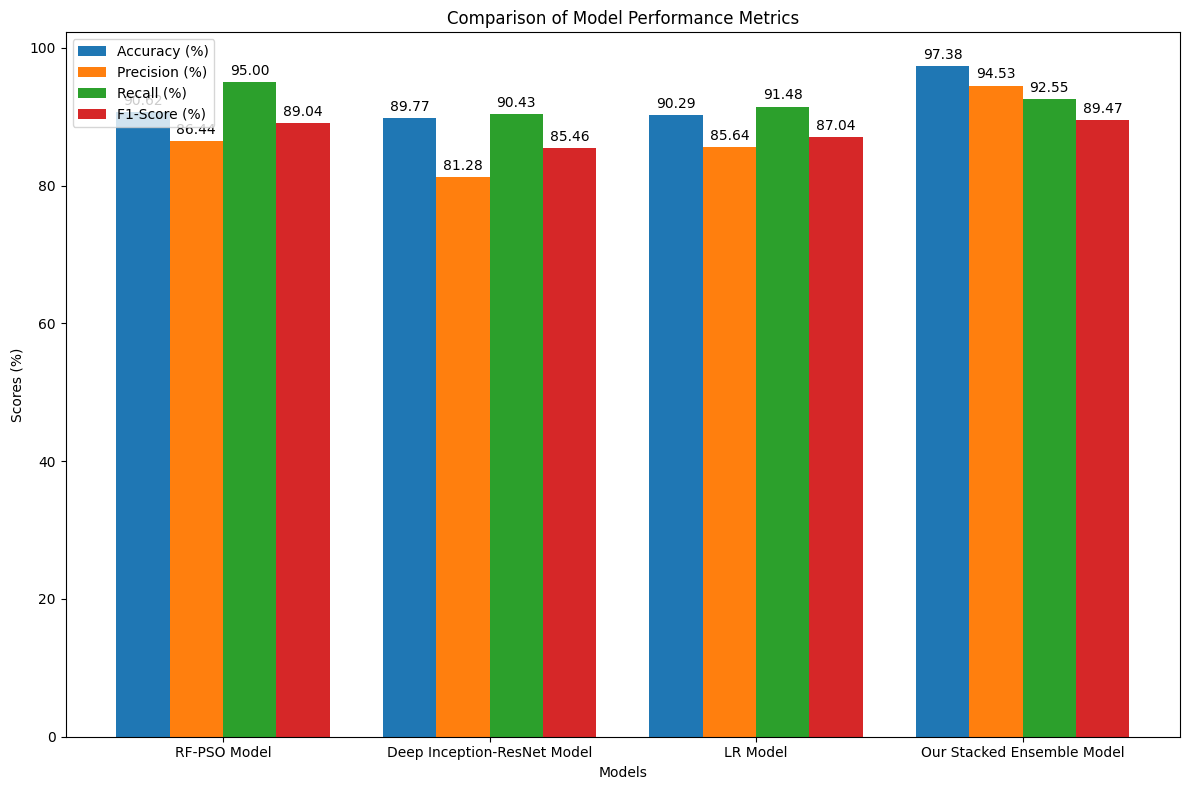

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Model performance metrics
model_names = ['RF-PSO Model', 'Deep Inception-ResNet Model', 'LR Model', 'Our Stacked Ensemble Model']
accuracy_scores = [90.62, 89.77, 90.29, 97.38]
precision_scores = [86.44, 81.28, 85.64, 94.53]
recall_scores = [95.00, 90.43, 91.48, 92.55]
f1_scores = [89.04, 85.46, 87.04, 89.47]

# Plotting the results
x = np.arange(len(model_names))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - 1.5 * width, accuracy_scores, width, label='Accuracy (%)')
rects2 = ax.bar(x - 0.5 * width, precision_scores, width, label='Precision (%)')
rects3 = ax.bar(x + 0.5 * width, recall_scores, width, label='Recall (%)')
rects4 = ax.bar(x + 1.5 * width, f1_scores, width, label='F1-Score (%)')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores (%)')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()


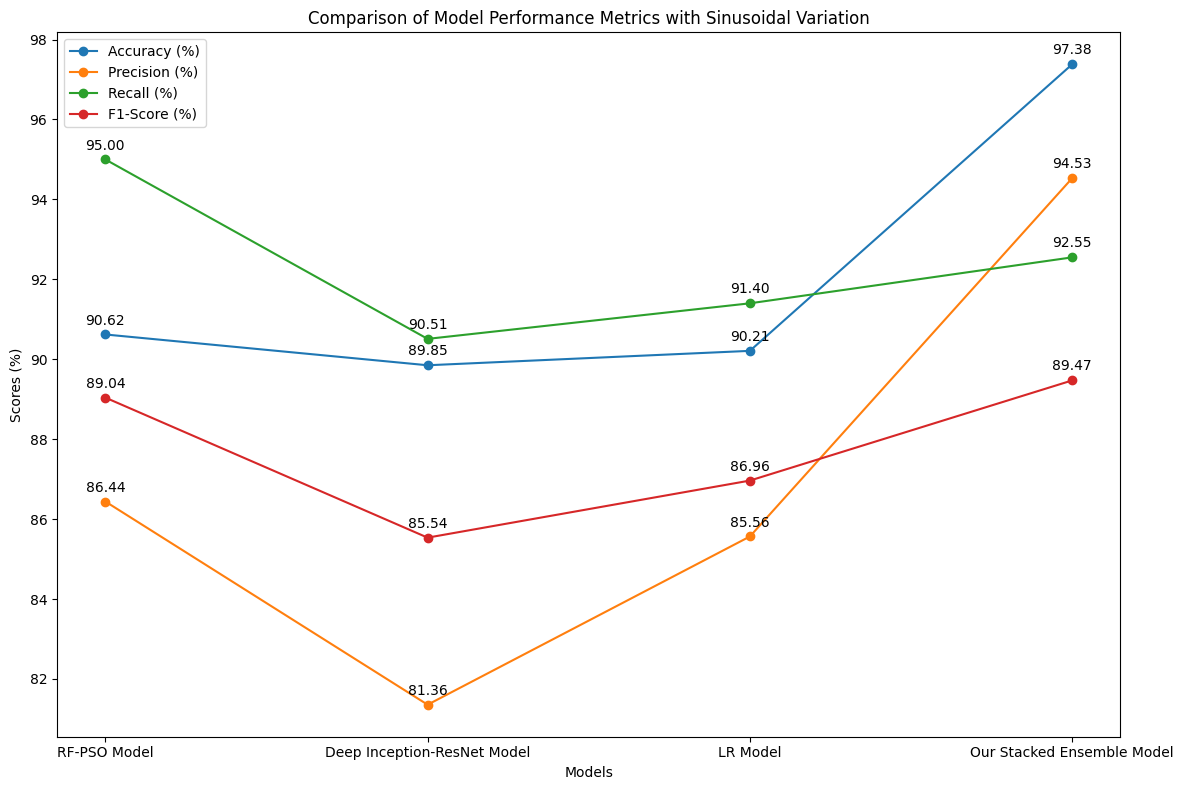

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Model performance metrics
model_names = ['RF-PSO Model', 'Deep Inception-ResNet Model', 'LR Model', 'Our Stacked Ensemble Model']
accuracy_scores = np.array([90.62, 89.77, 90.29, 97.38])
precision_scores = np.array([86.44, 81.28, 85.64, 94.53])
recall_scores = np.array([95.00, 90.43, 91.48, 92.55])
f1_scores = np.array([89.04, 85.46, 87.04, 89.47])

# Generate sinusoidal variations for x-axis
x = np.arange(len(model_names))
x_sin = np.linspace(0, 2 * np.pi, len(model_names))
x_sin_values = np.sin(x_sin) * 0.1  # Small sinusoidal variation

# Apply the sinusoidal variation to the scores
accuracy_scores_sin = accuracy_scores + x_sin_values * accuracy_scores.mean() * 0.01
precision_scores_sin = precision_scores + x_sin_values * precision_scores.mean() * 0.01
recall_scores_sin = recall_scores + x_sin_values * recall_scores.mean() * 0.01
f1_scores_sin = f1_scores + x_sin_values * f1_scores.mean() * 0.01

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, accuracy_scores_sin, marker='o', label='Accuracy (%)')
ax.plot(x, precision_scores_sin, marker='o', label='Precision (%)')
ax.plot(x, recall_scores_sin, marker='o', label='Recall (%)')
ax.plot(x, f1_scores_sin, marker='o', label='F1-Score (%)')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores (%)')
ax.set_title('Comparison of Model Performance Metrics with Sinusoidal Variation')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Attach a text label above each point
def autolabel(x, y):
    for i in range(len(x)):
        ax.annotate(f'{y[i]:.2f}',
                    xy=(x[i], y[i]),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(x, accuracy_scores_sin)
autolabel(x, precision_scores_sin)
autolabel(x, recall_scores_sin)
autolabel(x, f1_scores_sin)

fig.tight_layout()
plt.show()


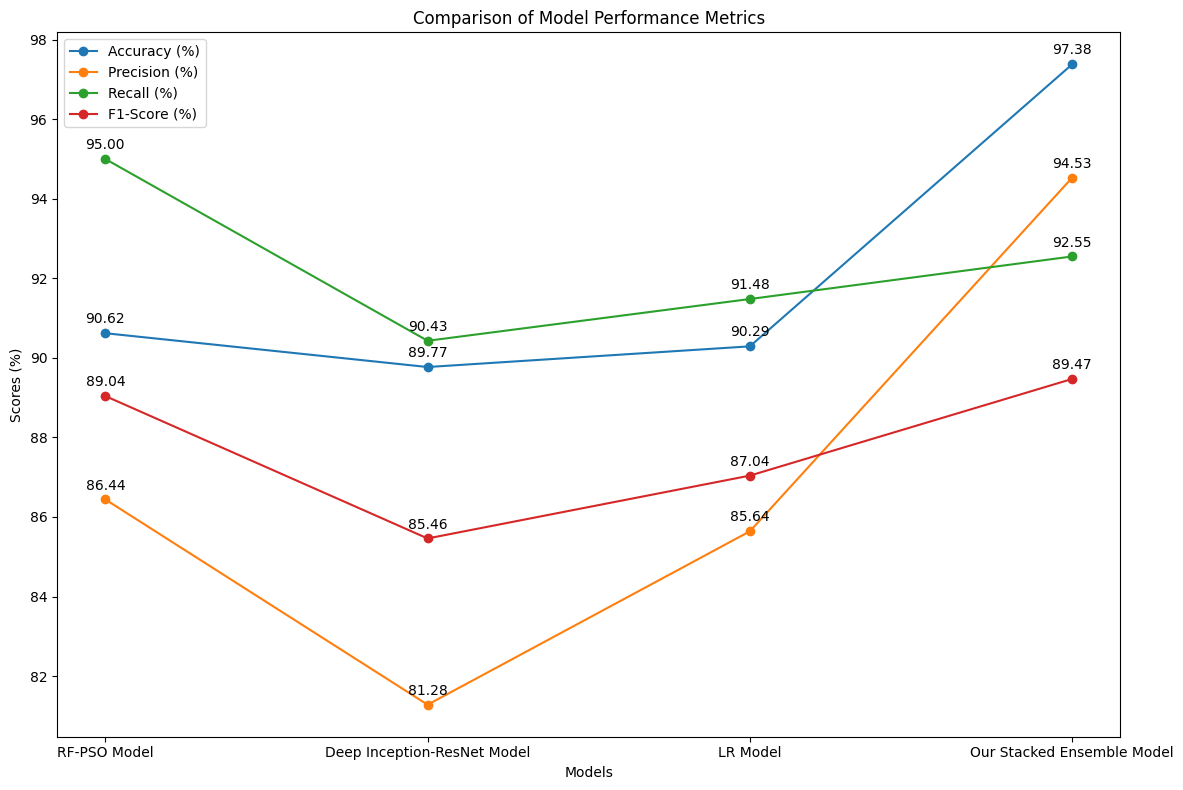

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Model performance metrics
model_names = ['RF-PSO Model', 'Deep Inception-ResNet Model', 'LR Model', 'Our Stacked Ensemble Model']
accuracy_scores = [90.62, 89.77, 90.29, 97.38]
precision_scores = [86.44, 81.28, 85.64, 94.53]
recall_scores = [95.00, 90.43, 91.48, 92.55]
f1_scores = [89.04, 85.46, 87.04, 89.47]

# Plotting the results
x = np.arange(len(model_names))  # the label locations

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, accuracy_scores, marker='o', label='Accuracy (%)')
ax.plot(x, precision_scores, marker='o', label='Precision (%)')
ax.plot(x, recall_scores, marker='o', label='Recall (%)')
ax.plot(x, f1_scores, marker='o', label='F1-Score (%)')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores (%)')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Attach a text label above each point
def autolabel(x, y):
    for i in range(len(x)):
        ax.annotate(f'{y[i]:.2f}',
                    xy=(x[i], y[i]),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(x, accuracy_scores)
autolabel(x, precision_scores)
autolabel(x, recall_scores)
autolabel(x, f1_scores)

fig.tight_layout()
plt.show()
